In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

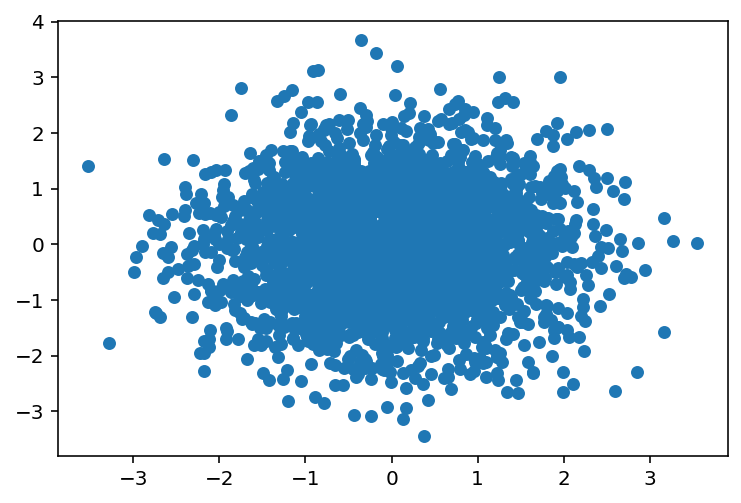

In [2]:
# Generate some data

X = np.random.randn(3000, 2)

# Plot the data

plt.scatter(X[:, 0], X[:, 1], s=30)

In [3]:
# Naive KNN

def naive_knn_for_loop(X, x_test, k=3):
    dists = np.zeros(X.shape[0])
    for i in range(X.shape[0]): # N iterations (N = number of data points)
        dists[i] = np.dot(X[i] - x_test, X[i] - x_test) # Time complexity: O(D)
    
    # Time complexity to create the distance array: O(N*D)

    # Now, we need to find the k smallest distances
    return np.argpartition(dists, k)[:k] # Time complexity: O(Nk) or O(N) depending on the implementation
  

In [4]:
naive_knn_for_loop(X, np.array([0, 0]))

array([1384, 1388, 2929])

In [5]:
X[naive_knn_for_loop(X, np.array([0, 0]))]

array([[-0.02403045, -0.00673354],
       [-0.00243893,  0.02568723],
       [-0.02888503, -0.03127704]])

In [6]:
%timeit naive_knn_for_loop(X, np.array([0, 0]))

12.4 ms ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# Implement using numpy

def naive_knn_numpy(X, x_test, k=3):
    dists = np.sum((X - x_test)**2, axis=1)
    #return np.partition(dists, k)[:k]
    sorted_dists = np.argsort(dists)
    return sorted_dists[:k]


In [8]:
naive_knn_numpy(X, np.array([0, 0]))

array([1384, 1388, 2929])

In [9]:
%timeit naive_knn_numpy(X, np.array([0, 0]))

241 µs ± 519 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
# Implement using numpy

def naive_knn_numpy(X, x_test, k=3):
    dists = np.sum((X - x_test)**2, axis=1)
    return np.argpartition(dists, k)[:k]
    #sorted_dists = np.argsort(dists)
    #return sorted_dists[:k]


In [11]:
%timeit naive_knn_numpy(X, np.array([0, 0]))

85.3 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


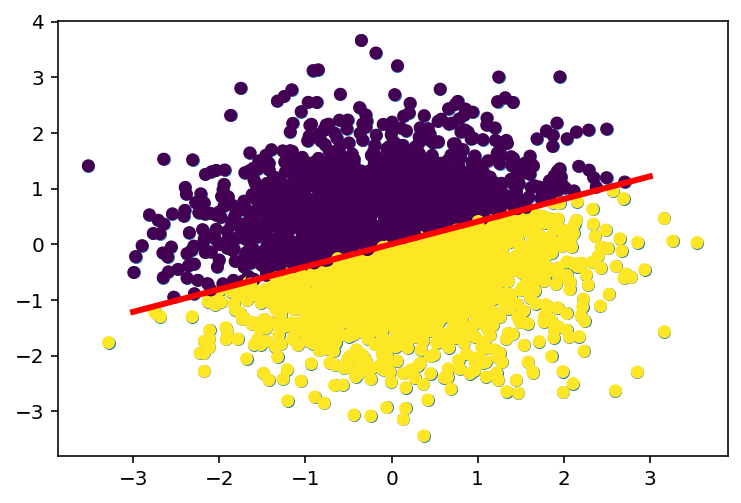

In [15]:
# Show LSH implementation step by step

# Creating a random separating hyperplane

w = np.random.randn(2)
b = np.random.randn(1)/4.0

# Plot the separating hyperplane

x = np.linspace(-3, 3, 100)
y = -(w[0] * x + b) / w[1]

plt.scatter(X[:, 0], X[:, 1], s=30)
plt.plot(x, y, 'r', linewidth=3)

# Color the points based on which side of the hyperplane they are on

colors = X[:, 0]*w[0] + X[:, 1]*w[1] + b > 0

plt.scatter(X[:, 0], X[:, 1], s=30, c=colors)

[-0.33410199 -1.27040586] [-0.17918695]
[-0.42003734  1.39768761] [-0.43795823]
[0.71691338 0.21293161] [-0.1219637]


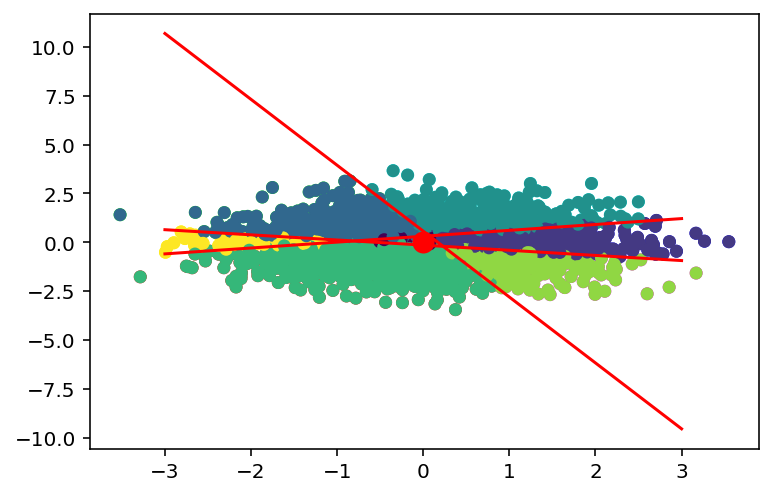

In [16]:
# Create three random hyperplanes and color the points based on which side of the hyperplane they are on. 
# there should be 2^3 = 8 different colors
# each separating hyperplane corresponds to a bit in the hash

hash = np.zeros((X.shape[0], 3)).astype(int)
ws = []
bs = []
# Cost for creating the hash table: O(N*H*D) 
for H in range(3): # H = number of hyperplanes
    w = np.random.randn(2)
    b = np.random.randn(1)/4.0
    ws.append(w)
    bs.append(b)
    hash[:, H] = X[:, 0]*w[0] + X[:, 1]*w[1] + b > 0 # D computations per iteration

# Convert the hash to a decimal number

hash_dec = np.sum(hash * 2**np.arange(3)[::-1], axis=1)

# Plot the hash

plt.scatter(X[:, 0], X[:, 1], s=30, c=hash)

# Plot the hash with the separating hyperplanes

plt.scatter(X[:, 0], X[:, 1], s=30, c=hash_dec)
for w, b in zip(ws, bs):
    print(w, b)
    x = np.linspace(-3, 3, 100)
    y = -(w[0] * x + b) / w[1]
    plt.plot(x, y, 'r')

# Mark the test point

x_test = np.array([0, 0])
plt.scatter(x_test[0], x_test[1], s=100, c='r')

In [17]:
df = pd.DataFrame(hash)
df.columns = ['h1', 'h2', 'h3']
df['hash_dec'] = hash_dec
df['x'] = X[:, 0]
df['y'] = X[:, 1]

df.head(10)


,h1,h2,h3,hash_dec,x,y
0,0,1,0,2,-0.246232,1.244987
1,0,1,1,3,0.871390,0.846192
2,1,0,0,4,-0.105102,-1.672524
3,0,1,1,3,0.529090,0.588405
4,0,0,1,1,1.423872,-0.466313
5,0,1,0,2,0.037017,0.396019
6,1,0,0,4,-0.883974,-1.743182
7,1,0,1,5,0.337388,-0.393713
8,0,0,1,1,1.708228,-0.014551
9,1,0,0,4,-0.495120,-0.765020


In [18]:

pd.DataFrame(hash).value_counts()

0  1  2
1  0  0    943
0  1  0    559
      1    506
   0  1    461
1  0  1    347
0  0  0    112
1  1  0     72
dtype: int64

In [19]:
# Predict the K nearest neighbors using LSH

# Compute the hash for the test point

x_test = np.array([0, 0])
hash_test = x_test[0]*ws[0][0] + x_test[1]*ws[0][1] + bs[0] > 0

#convert to decimal
hash_test_dec = np.sum(hash_test * 2**np.arange(3)[::-1])

hash_test_dec

0

In [20]:
# Find subset of points with the same hash

X_subset = X[hash_dec == hash_test_dec]
X_subset.shape

(112, 2)

In [21]:
# Now, we can use the naive KNN implementation to find the K nearest neighbors

ix = naive_knn_numpy(X_subset, x_test, k=3)
X_subset[ix]

array([[-0.00243893,  0.02568723],
       [-0.02403045, -0.00673354],
       [-0.02888503, -0.03127704]])

In [22]:
%timeit naive_knn_numpy(X_subset, x_test, k=3)

12.6 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
# Using FAISS from Facebook

import faiss

# Create an index
index = faiss.IndexFlatL2(2)   # build the index

# Add the data to the index
index.add(X.astype(np.float32))                  # add vectors to the index


In [33]:
# Search for the K nearest neighbors
D, I = index.search(x_test.astype(np.float32).reshape(1, -1), k=3)     # actual search


51.3 µs ± 256 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
D

array([[0.0006228 , 0.00066578, 0.0018126 ]], dtype=float32)

In [30]:
I

array([[1384, 1388, 2929]])

In [31]:
X[I[0]]

array([[-0.02403045, -0.00673354],
       [-0.00243893,  0.02568723],
       [-0.02888503, -0.03127704]])

In [34]:
%timeit index.search(x_test.astype(np.float32).reshape(1, -1), k=3)

51.4 µs ± 240 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [37]:
# Now, run on GPU

res = faiss.StandardGpuResources()  # use a single GPU

# Create an index
index = faiss.IndexFlatL2(2)   # build the index

gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index)

# Add the data to the index
gpu_index_flat.add(X.astype(np.float32))                  # add vectors to the index


In [38]:
%timeit gpu_index_flat.search(x_test.astype(np.float32).reshape(1, -1), k=3)

79.6 µs ± 73.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# The above is slow because
# 1. We are copying the data to the GPU
# 2. We are copying the data back to the CPU
# 3. Not enough data and low dimensional data